# ACM30010 Assignment 3
# Machine Learning Project
## Ronan McCormack 
## 17328461

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Outline

Idea: From a dataset containing all box scores throughout an NBA regular season, select certain players and train models that classify each player based on several performance-indicating variables.

The model should then take as input an individual box score, and output the player most likely to have logged that statline.

- Season: 2017/18
- Players: Can be specified
- Classifying variables: Points, Rebounds, Assists, Steals, Blocks, Turnovers, Free throws attempted, Field goal %


We'll first import and process the data. 
The player names and the classifying variables will be specified.

We'll analyse and compare the players' data.

We'll run several machine learning algorithms from Sci Kit learn on the processed data, namely: 
- Support Vector Machines
- Logistic Regression
- Perceptron
- Stochastic Gradient Descent

We'll then compare the accuracy of each model, and repeat for a different group of players.

---

## The Dataset

Note: I have the dataset saved on my pc in a subdirectory off the working directory named 'Data'

In [2]:
raw_set = pd.read_csv('Data/2017_18_playerBoxScore.csv') # Load in dataset of all box scores from 17/18 season

In [3]:
raw_set.shape

(26109, 51)

In [4]:
raw_set.head(5)

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,...,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptDayOff
0,2017-10-17,08:00,Regular,Brown,Jaylen,BOS,East,Atlantic,Away,Loss,...,0.5000,1,5,6,CLE,East,Central,Home,Win,0
1,2017-10-17,08:00,Regular,Irving,Kyrie,BOS,East,Atlantic,Away,Loss,...,1.0000,2,2,4,CLE,East,Central,Home,Win,0
2,2017-10-17,08:00,Regular,Tatum,Jayson,BOS,East,Atlantic,Away,Loss,...,1.0000,4,6,10,CLE,East,Central,Home,Win,0
3,2017-10-17,08:00,Regular,Horford,Al,BOS,East,Atlantic,Away,Loss,...,0.7143,0,7,7,CLE,East,Central,Home,Win,0
4,2017-10-17,08:00,Regular,Hayward,Gordon,BOS,East,Atlantic,Away,Loss,...,0.0000,0,1,1,CLE,East,Central,Home,Win,0


The dataset contains the box scores of every game of every player throughout the 2017-18 NBA regular season. The dataset contains 51 columns, most of which are of little interest to us. We'll only keep columns with player names and some stats that are most likely to distinguish players. 

We'll also only consider the box scores of certain players of our choosing.

---

## Process Data

The variables we will consider as predictors will be:

- points scored
- assists
- total rebounds
- steals
- blocks
- turnovers
- field goal %
- free throws attempted
 


In [5]:
vars1 = ["playDispNm","playPTS","playAST","playTRB","playSTL","playBLK","playTO","playFG%","playFTA"]
set1 = raw_set[vars1]

In [6]:
set1.head(1)

,playDispNm,playPTS,playAST,playTRB,playSTL,playBLK,playTO,playFG%,playFTA
0,Jaylen Brown,25,0,6,3,0,3,0.4783,2


We'll keep only rows corresponding to players of our choosing. It'll be easier to classify players who typically log contrasting box scores in games as there are many players in the NBA who, statistically, perform very similar. 

Also, we'd expect more accuracy when choosing players who played many games throughout the season, rather than those who may have missed many games due to injury etc.

We'll store the player names in a list, which can be easily edited.

I have made two lists of players here.  
*players_1* consists of players who tend to register contrasting statlines.  
*players_2* consists of that season's All-NBA 1st Team. I would anticipate a lower degree of accuracy when classifying box scores of these guys, as they all tend to log big numbers in some categories.

In [7]:
players_1 = ['Ben Simmons', 'Clint Capela', 'Kyrie Irving']
players_2 = ['Anthony Davis', 'Damian Lillard', 'James Harden', 'Kevin Durant', 'LeBron James']


First, we'll go with *players_1*, and produce the dataset accordingly.

In [8]:
players = players_1

In [9]:
# initialise with rows belonging to the first player in the list
set2 = set1.loc[(set1['playDispNm']==players[0])]
 
# append on rows belonging to the other players    
for name in players[1:]:
    set2 = set2.append(set1.loc[(set1['playDispNm']==name)], ignore_index=True)

The dataset now contains the boxscores of each player throughout the season.


In [10]:
set2.head()

,playDispNm,playPTS,playAST,playTRB,playSTL,playBLK,playTO,playFG%,playFTA
0,Ben Simmons,18,5,10,2,1,1,0.4667,6
1,Ben Simmons,11,5,11,1,0,4,0.3636,6
2,Ben Simmons,18,8,10,0,0,3,0.4375,8
3,Ben Simmons,21,10,12,1,0,4,0.7273,6
4,Ben Simmons,14,9,7,3,1,4,0.4118,2


### Analysis of Dataset 

We'll make some initial comparisons of the chosen players. 

First, how many games has each played?

Text(0.5, 1.0, 'Games Played by Each Player')

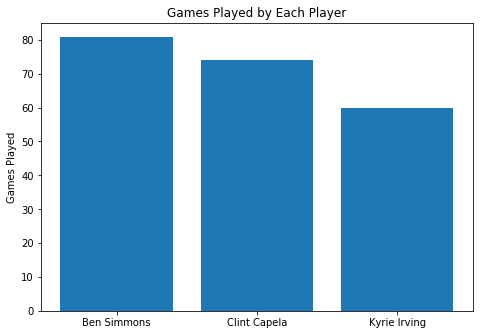

In [11]:
# A look at the games played by the players

games_played = [set2.loc[set2['playDispNm']==name].shape[0] for name in players]


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(players,games_played)
ax.set_ylabel('Games Played')
ax.set_title('Games Played by Each Player')
    

Now, we'll tabulate their season averages

In [12]:
vars1.remove('playDispNm')

In [13]:
# Compare season averages of each player

avgs1 = set2.loc[(set2['playDispNm']==players[0])].drop('playDispNm', axis=1)

df3 = pd.DataFrame(avgs1.mean(), index=None, columns = [players[0]])

for name in players[1:]:
    avgs = set2.loc[(set2['playDispNm']==name)].drop('playDispNm', axis=1)
    df3[name] = pd.DataFrame(avgs.mean())

df3

,Ben Simmons,Clint Capela,Kyrie Irving
playPTS,15.790123,13.864865,24.433333
playAST,8.148148,0.918919,5.100000
playTRB,8.148148,10.837838,3.783333
playSTL,1.740741,0.770270,1.083333
playBLK,0.839506,1.864865,0.283333
playTO,3.432099,1.405405,2.316667
playFG%,0.551230,0.654964,0.485183
playFTA,4.209877,3.472973,4.350000


We can see that the three players in *players_1* differ significantly in their averages of almost every category. This bodes well for the classification models.

Continuing with the data processsing we'll assign playFG% to bins from 0-5, and make a dataframe detailing the bins for reference.

In [14]:
set3 = set2

In [15]:
bins = [-0.1, 0.3, 0.4, 0.5, 0.6, 0.75, 1.0]
labels = [n for n in range(len(bins)-1)]

set3['playFG%'] = pd.cut(set3["playFG%"], bins, labels = labels)

# Make dataframe containing FG% bins and labels
bins_df = pd.DataFrame({
    'playFG%': ['0.0-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.75', '0.75-1.0'],
    'Bin': labels})

bins_df

,playFG%,Bin
0,0.0-0.3,0
1,0.3-0.4,1
2,0.4-0.5,2
3,0.5-0.6,3
4,0.6-0.75,4
5,0.75-1.0,5


Next, we assign an integer value to each player name. Then we'll make another dataframe containing only the player names and their code for reference.

In [16]:
set3["playDispNm"] = set3["playDispNm"].astype('category')
set3["playCode"] = set3["playDispNm"].cat.codes

player_codes = set3[["playDispNm","playCode"]]
player_codes.drop_duplicates(subset='playDispNm', keep='first', inplace=True)

player_codes

,playDispNm,playCode
0,Ben Simmons,0
81,Clint Capela,1
155,Kyrie Irving,2


We can drop the playDispNm column, now that we have the code to identify players

In [17]:
set3.drop(['playDispNm'], axis=1, inplace=True)

set3.head()

,playPTS,playAST,playTRB,playSTL,playBLK,playTO,playFG%,playFTA,playCode
0,18,5,10,2,1,1,2,6,0
1,11,5,11,1,0,4,1,6,0
2,18,8,10,0,0,3,2,8,0
3,21,10,12,1,0,4,4,6,0
4,14,9,7,3,1,4,2,2,0


Finally, this is the dataframe we will use for classification

### Splitting Data

Next, the data must be split randomly into training and testing sets.

The function *train_test_split* from the *scikit-learn* library will do this for us. We'll set the test size to *0.2*, thus splitting the data 80-20 between train and test.

The predictor variables are all those in the dataset but for *playCode* which is the target variable that we are trying to predict.

In [18]:
from sklearn.model_selection import train_test_split

predictors = set3.drop('playCode', axis=1)
target = set3['playCode']

x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=0)

In [19]:
predictors.shape

(215, 8)

---

## Schemes

### Support Vector Classification

The first method we'll use to classify our data will be Support Vector Classification

We'll import SVC from the scikit-learn library.

We'll train the model on *x_train* and *y_train* and get a measure of its accuracy by implementing it on the test data, using *svc.score()*.

In [20]:
# Support Vector Classification

from sklearn.svm import SVC

svc = SVC()

# Train the model on x_train, y_train
svc.fit(x_train, y_train)

# The model is now trained

# Compare predicted values to actual to measure accuracy 
acc_svc = round(svc.score(x_test,y_test)*100, 2)
print(acc_svc,'%')

# support vectors
svc.support_vectors_

79.07 %


array([[16.,  9.,  8., ...,  3.,  1.,  2.],
       [12., 15., 13., ...,  4.,  2.,  2.],
       [ 4.,  7.,  6., ...,  4.,  0.,  2.],
       ...,
       [21.,  4.,  6., ...,  0.,  1.,  4.],
       [28.,  2.,  8., ...,  4.,  2.,  4.],
       [23.,  3.,  1., ...,  1.,  2.,  4.]])

### Logistic Regression

Now we'll try Logistic Regression.
As before, we'll import LinearRegression from the scikit-learn library, trainthe model on the training data and test its accuracy on the test data.

In [21]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression() # all parameters are set to defaults

# Train the model on x_train, y_train
logreg.fit(x_train, y_train)

# The model is now trained

# Compare predicted values to actual to measure accuracy 
acc_logreg = round(logreg.score(x_test,y_test)*100, 2)
print(acc_logreg,'%')



93.02 %


### Other Schemes

We'll also quickly try the *Perceptron* and *Stochastic Gradient Descent* schemes from the sklearn library.

In [22]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
acc_perceptron = round(perceptron.score(x_test,y_test)*100, 2)
print(acc_perceptron,'%')



86.05 %


In [23]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
acc_sgd = round(sgd.score(x_test, y_test)*100, 2)
print(acc_sgd,'%')

88.37 %


## Results

Compare the accuracy of each model:

In [24]:
compare = pd.DataFrame({'Model': ['Support Vector Machines', 'Logistic Regression', 'Perceptron', 'Stochastic Gradient Descent'],
                       'Score': [acc_svc, acc_logreg, acc_perceptron, acc_sgd]})
compare.sort_values(by='Score', ascending=False)

,Model,Score
1,Logistic Regression,93.02
3,Stochastic Gradient Descent,88.37
2,Perceptron,86.05
0,Support Vector Machines,79.07


## Input Our Own Statline

We'll make up a statline and see which of our players the logistic regression model thinks it's most likely to belong to.

You'll be asked to enter values for each variable. 

**Recall the bins for FG% range from 0-5 as follows:**

In [25]:
bins_df

,playFG%,Bin
0,0.0-0.3,0
1,0.3-0.4,1
2,0.4-0.5,2
3,0.5-0.6,3
4,0.6-0.75,4
5,0.75-1.0,5


In [26]:
columns = ['playPTS', 'playAST', 'playTRB', 'playSTL', 'playBLK', 'playTO', 'playFG%', 'playFTA']

boxscore = np.transpose([[0],[0],[0],[0],[0],[0],[0],[0]])

In [27]:
for i in range(len(columns)):
    boxscore[0][i] = np.transpose([input((str(columns[i]) + ": "))])
    
df = pd.DataFrame(boxscore, columns = columns)

playPTS: 5
playAST: 5
playTRB: 5
playSTL: 5
playBLK: 5
playTO: 5
playFG%: 5
playFTA: 5


In [28]:
prediction = int(logreg.predict(df))

# output player name

output = player_codes.loc[player_codes['playCode'] == prediction]['playDispNm']


print(df)
print(output.values)

   playPTS  playAST  playTRB  playSTL  playBLK  playTO  playFG%  playFTA
0        5        5        5        5        5       5        5        5
[Ben Simmons]
Categories (3, object): [Ben Simmons, Clint Capela, Kyrie Irving]


---
---
---

## Again, With Different Players

That worked well for those particular players, but now let's see how accurate the models will be for the other list of players, *players_2*

In [29]:
players_2 = ['Anthony Davis', 'Damian Lillard', 'James Harden', 'Kevin Durant', 'LeBron James']
players=players_2

In [30]:
# initialise with rows belonging to the first player in the list
set2 = set1.loc[(set1['playDispNm']==players[0])]
 
# append on rows belonging to the other players    
for name in players[1:]:
    set2 = set2.append(set1.loc[(set1['playDispNm']==name)], ignore_index=True)

Text(0.5, 1.0, 'Games Played by Each Player')

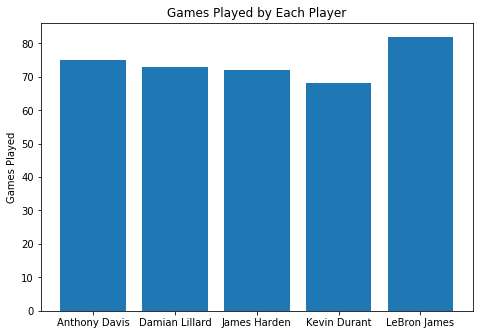

In [31]:
# A look at the games played by the players

games_played = [set2.loc[set2['playDispNm']==name].shape[0] for name in players]


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(players,games_played)
ax.set_ylabel('Games Played')
ax.set_title('Games Played by Each Player')

In [32]:
# Compare season averages of each player

avgs1 = set2.loc[(set2['playDispNm']==players[0])].drop('playDispNm', axis=1)

df3 = pd.DataFrame(avgs1.mean(), index=None, columns = [players[0]])

for name in players[1:]:
    avgs = set2.loc[(set2['playDispNm']==name)].drop('playDispNm', axis=1)
    df3[name] = pd.DataFrame(avgs.mean())

df3

,Anthony Davis,Damian Lillard,James Harden,Kevin Durant,LeBron James
playPTS,28.133333,26.876712,30.430556,26.352941,27.451220
playAST,2.333333,6.589041,8.736111,5.382353,9.085366
playTRB,11.120000,4.452055,5.375000,6.838235,8.682927
playSTL,1.533333,1.068493,1.750000,0.735294,1.426829
playBLK,2.560000,0.369863,0.694444,1.750000,0.865854
playTO,2.160000,2.808219,4.375000,3.058824,4.243902
playFG%,0.537844,0.436673,0.447806,0.523874,0.541089
playFTA,7.973333,7.369863,10.097222,5.941176,6.475610


This time it's evident that it'll be harder to classify the players.

---

In [33]:
set3 = set2

In [34]:
bins = [-0.1, 0.3, 0.4, 0.5, 0.6, 0.75, 1.0]
labels = [n for n in range(len(bins)-1)]

set3['playFG%'] = pd.cut(set3["playFG%"], bins, labels = labels)

# Make dataframe containing FG% bins and labels
bins_df = pd.DataFrame({
    'playFG%': ['0.0-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.75', '0.75-1.0'],
    'Bin': labels})


In [35]:
set3["playDispNm"] = set3["playDispNm"].astype('category')
set3["playCode"] = set3["playDispNm"].cat.codes

player_codes = set3[["playDispNm","playCode"]]
player_codes.drop_duplicates(subset='playDispNm', keep='first', inplace=True)

player_codes

,playDispNm,playCode
0,Anthony Davis,0
75,Damian Lillard,1
148,James Harden,2
220,Kevin Durant,3
288,LeBron James,4


We can drop the playDispNm column, now that we have the code to identify players

In [36]:
set3.drop(['playDispNm'], axis=1, inplace=True)

### Splitting Data

In [37]:
from sklearn.model_selection import train_test_split

predictors = set3.drop('playCode', axis=1)
target = set3['playCode']

x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=1)

In [38]:
predictors.shape

(370, 8)

## Schemes

In [39]:
# Support Vector Classification

from sklearn.svm import SVC

svc = SVC()

# Train the model on x_train, y_train
svc.fit(x_train, y_train)

# The model is now trained

# Compare predicted values to actual to measure accuracy 
acc_svc = round(svc.score(x_test,y_test)*100, 2)
print(acc_svc,'%')

# support vectors
svc.support_vectors_

44.59 %


array([[17.,  3.,  6., ...,  1.,  2.,  8.],
       [28.,  2.,  6., ...,  1.,  2.,  7.],
       [34.,  5.,  9., ...,  2.,  4.,  8.],
       ...,
       [29., 10., 11., ...,  5.,  3., 10.],
       [39.,  7.,  1., ...,  7.,  4.,  5.],
       [25., 14.,  8., ...,  3.,  3.,  9.]])

### Logistic Regression

Now we'll try Logistic Regression.
As before, we'll import LinearRegression from the scikit-learn library, train the model on the training data and test its accuracy on the test data.

In [40]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression() # all parameters are set to defaults

# Train the model on x_train, y_train
logreg.fit(x_train, y_train)

# The model is now trained

# Compare predicted values to actual to measure accuracy 
acc_logreg = round(logreg.score(x_test,y_test)*100, 2)
print(acc_logreg,'%')



71.62 %


### Other Schemes

We'll also quickly try the *Perceptron* and *Stochastic Gradient Descent* schemes from the sklearn library.

In [41]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
acc_perceptron = round(perceptron.score(x_test,y_test)*100, 2)
print(acc_perceptron,'%')



51.35 %


In [42]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
acc_sgd = round(sgd.score(x_test, y_test)*100, 2)
print(acc_sgd,'%')

50.0 %


## Results

Compare the accuracy of each model:

In [43]:
compare = pd.DataFrame({'Model': ['Support Vector Machines', 'Logistic Regression', 'Perceptron', 'Stochastic Gradient Descent'],
                       'Score': [acc_svc, acc_logreg, acc_perceptron, acc_sgd]})
compare.sort_values(by='Score', ascending=False)

,Model,Score
1,Logistic Regression,71.62
2,Perceptron,51.35
3,Stochastic Gradient Descent,50.00
0,Support Vector Machines,44.59


As expected, the accuracy of the models is significantly lower for the second list of players.

---

# Conclusion



As was to be expected, the models were more accurate at classifying players from the first list than the second.

For each set of players, the ranking of models in terms of accuracy was the same, ith logistic regression leading the way.

The models could become more accurate with the inclusion of other variables in the box score, such as three pointers attempted (3PA) or minutes played.

As far as I can tell, these models and analysis haven't much practical use and don't provide any meaningful or novel insight. Nevertheless, I find it kind of cool to be able to enter a statline and have the model output the player, from a specified subset of players, most likely to log that statline based on the data from the 2017/18 season.

I would have liked to go into the details of the ML functions imported from the scikit-learn library but, unfortunately, I didn't find the time.